# Investigating fluxes of stratification at the Weddell Sea mooring plume

Rowan Brown | 26.02.2025

This notebook is for exploring profiles at the Weddell Sea mooring (and in the MITgcm plume simulations) in terms of stratifiation fluxes. In other words, it's to investigate how to create initial conditions that reflect the stratification at the mooring in the Weddell Sea *combined* with estimates of surface heat and salt fluxes, which *should* recreate the observed plume.

In [92]:
# Imports
import numpy as np
import pandas as pd
import xmitgcm
import matplotlib.pylab as plt
from mpl_toolkits import axisartist
from mpl_toolkits.axes_grid1 import host_subplot
import xmitgcm.file_utils
import xmitgcm.utils
from MITgcmutils import density
import xarray as xr
import gsw
import basic_model_anayses as bma
from datetime import datetime

import sys
sys.path.insert(1, '../obs_analyses/')
import mooring_analyses
import woa_analyses

## Initial condition stability

Here, we're going to look at salinity and temperature profiles, as used in the model, along with potential density or buoyancy frequency. The result will show how stable a certain combination of temperature and salinity initial conditions end up being. Note that salinities are absolute and temperatures are potential, since this is what *eosType=TEOS10* uses in MITgcm.

Minimum N2 (should be positive!): 2.8921455071686857e-07


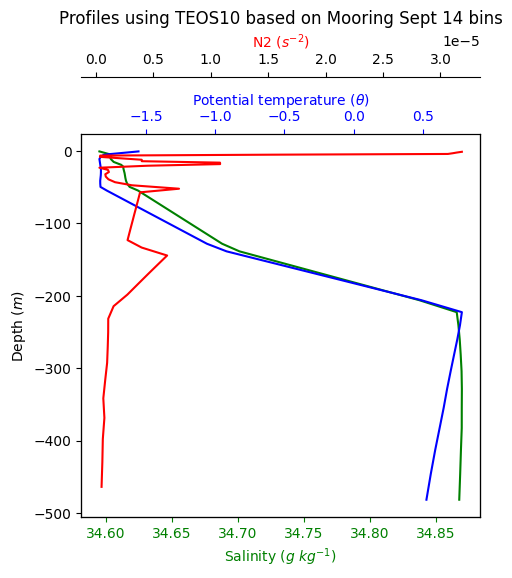

In [25]:
# Opening mds binary to get model depths
ds = xmitgcm.open_mdsdataset('../MITgcm/so_plumes/mrb_036/', geometry='cartesian', prefix=['S','T'], iters=[0])
depths = ds['Z'].values

# Opening init binaries 
open_bin = lambda f : xmitgcm.utils.read_raw_data('../MITgcm/so_plumes/binaries/'+f, shape=(50,150,150), dtype=np.dtype('>f4') )

# Binary names and plotting dictionaries
theta = "theta.mooringSept14.50x150x150.500m.bin"
sa = "SA.mooringSept14.50x150x150.500m.bin"

#== Plotting ==#
fig, ax = plt.subplots(figsize=(5,6))
ax.set_ylabel('Depth ($m$)')

# Salinity
ax.set_xlabel('Salinity ($g$ $kg^{-1}$)')
ax.plot(open_bin(sa)[:,75,75],depths,c='g')
ax.xaxis.label.set_color('g')
ax.tick_params(axis='x', colors='g')

# Temperature
ax2 = ax.twiny()
ax2.set_xlabel(r'Potential temperature ($\theta$)')
ax2.plot(open_bin(theta)[:,75,75],depths,c='b')
ax2.xaxis.label.set_color('b')
ax2.tick_params(axis='x', colors='b')

# Potential density OR N**2 (dealer's choice)
ax3 = ax.twiny()
ax3.spines.top.set_position(("axes", 1.15))
ax3.set_xlabel('N2 ($s^{-2}$)')#Potential density ($kg$ $m^{-3}$)')
sa_profile = open_bin(sa)[:,75,75]
theta_profile = open_bin(theta)[:,75,75]
ct_profile = gsw.CT_from_pt(sa_profile,theta_profile)
N2, p_mid = gsw.Nsquared(sa_profile,ct_profile,gsw.p_from_z(depths,-69.0005),-69.0005)
ax3.plot(N2,gsw.z_from_p(p_mid,-69.0005),c='r')
print("Minimum N2 (should be positive!): "+str(min(N2)))
ax3.xaxis.label.set_color('r')
ax3.tick_params(axis='x', colors='k')

plt.title('Profiles using TEOS10 based on Mooring Sept 14 bins')
plt.tight_layout()

## Fluxes of stratification

From above, we now have a way to verify the stability of our initial conditions. So, the next step is to roughly estimate how much heat and salt flux occured through the surface at the mooring. 

### A couple observations:
* For now, consider that sea water temperature cannot go below -1.8. If the temperature at 50 m is -1.8, in the autumn runs (N.H. autumn, so S.H. spring), then the whole surface above 50 m is likely also at -1.8. (Consider (a) that we're assuming a surface-driven plume; hence homogenised/cold/as-dense-as-can-be, and (b) the autumn WOA climatology is relatively homogenous; only the summer has a pronounced subsurface cold layer)
* Salinity in the WOA climatologies *for all seasons* is fresher at the surface than at 50 m; in the autumn it is ~0.1 PSU less at the surface than at 25 m, with a very steep halocline. Another less steep halocline exists at 125 m. In a spring plume with breaking up sea ice, this is what we might expect. However, if the ice is breaking up due to wind coupled with intense *cooling*, i.e., a cold springtime storm, which explains the ostensibly heat-flux-driven plume, then perhaps there would be less melt, less of a freshwater cap, and maybe even continued brine rejection. I can think of no strong argument against this case, and hence I will assume that the salinity above 50 m is the same as at 50 m, just like with the temperature.

### Calculating heat content and flux
Heat content in a $1$ m $\times$ $1$ m column of water is calculated by integrating over depth, i.e., 
$$
    HC = \int \rho\ c_p\ T\ dz,
$$
where in this case $c_p$ is the isobaric heat capacity in $J\ kg^{-1}\ ℃^{-1}$ (calculated using gsw_cp_t_exact), $\rho$ is the in-situ (I think) density in $kg\ m^{-3}$, and $T$ is in-situ (I think) temperature in $℃$. Integrating over depth (and the $1$ m $\times$ $1$ m column) gives units of $J$. We *could* using $T-T_{ref}$ but I don't see a good argument why, especially since we're only interested in the general rate of change of heat content. HF is HC derived over time, i.e., 
$$
    HF = \frac{d\ HC}{dt} 
$$

### Calculating salt content and flux
Similar calculations to heat flux, except the total salt content is found by simply multiplying the salinity by the density. In other words,
$$
    SC = \int \rho\ S\  dz \rightarrow SF = \frac{d\ SC}{dt},
$$
where the unit of salt content is *g* (consider, $\rho [kg/m^3]\ S[g/kg]$) and the unit of salt flux is *g* per day.

In [144]:
# Opening the mooring data
time_delta='hour'
ds = mooring_analyses.open_mooring_ml_data(time_delta)
ds = mooring_analyses.correct_mooring_salinities(ds)
if time_delta=='hour': ds = ds.isel(day=slice(0,-1,2)) # In this case we need to alias the data

# Adding "cell" thicknesses associated with each of the 3 active sensors
dz = [(135-50)/2,np.nan,(135-50)/2+(220-135)/2,np.nan,(220-135)/2,np.nan]
ds = ds.assign_coords(dz=("depth",dz))

# Calculating the quantity of heat in the water column
ds['cp'] = gsw.cp_t_exact(ds['SA'],ds['T'],ds['p_from_z']) # Isobaric cp 
ds['rho'] = gsw.rho_t_exact(ds['SA'],ds['T'],ds['p_from_z']) # In-situ density
ds['HC'] = (ds['rho']*ds['cp']*ds['T']*ds['dz']).sum(dim='depth') # Unit: J
ds['HF'] = ds['HC'].diff('day')/7200 #.differentiate('day',datetime_unit="D") # Unit: J/s (i.e., W)

# Calculating the quantity of salt in the water column
ds['SC'] = (ds['SA']*ds['rho']*ds['dz']).sum(dim='depth') # Unit: g
ds['SF'] = ds['SC'].diff('day')/7200 #.differentiate('day',datetime_unit="D") # Unit: g/day

print("You might want to test to make sure your calcs (like sum in depth and then differentiate) are working properly")

/albedo/home/robrow001/model_analyses/../obs_analyses/mooring_analyses.py:78: RuntimeWarning: invalid value encountered in scalar divide
  new_df['var'] = df.resample('h').apply(lambda df : np.sum(df['weights']*df['var'])/np.sum(df['weights']))
/albedo/home/robrow001/model_analyses/../obs_analyses/mooring_analyses.py:78: RuntimeWarning: invalid value encountered in scalar divide
  new_df['var'] = df.resample('h').apply(lambda df : np.sum(df['weights']*df['var'])/np.sum(df['weights']))
/albedo/home/robrow001/model_analyses/../obs_analyses/mooring_analyses.py:78: RuntimeWarning: invalid value encountered in scalar divide
  new_df['var'] = df.resample('h').apply(lambda df : np.sum(df['weights']*df['var'])/np.sum(df['weights']))


Mooring data opened
 50 m 12-month mean from mooring: 34.369026301369864
 50 m 12-month mean from WOA:     34.38139177087235
Difference: -0.012365469502483961

135 m 12-month mean from mooring: 34.62639991010118
135 m 12-month mean from WOA:     34.61529681898143
Difference: 0.011103091119750275

220 m 12-month mean from mooring: 34.65630465643637
220 m 12-month mean from WOA:     34.69025839191593
Difference: -0.03395373547956382
Salinities corrected
You might want to test to make sure your calcs (like sum in depth and then differentiate) are working properly


Average heat flux during Sept 14--16: -1604.2472533092364 W
Average salt flux during Sept 14--16: -0.029264986289034154 g/s


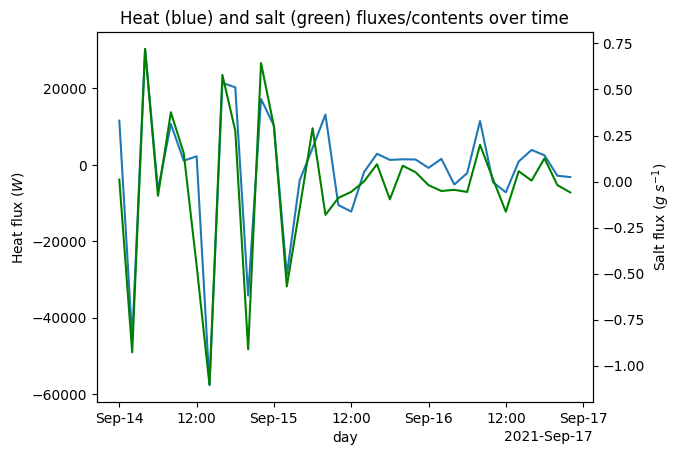

In [146]:
# Plotting timeseries
fig,ax = plt.subplots()
ds = ds.sel(day=slice("2021-09-14", "2021-09-16"))
#ds['HF2'] = ds['HF']/(24*60*60) # Divide by s per day to get W/m**2
#ds['HF2'].plot(ax=ax,label='Heat flux ($W$)')
ds['HF'].plot(ax=ax,label='Heat flux)')
ax2 = ax.twinx()
#ds['SF'].plot(ax=ax2,c='g',label='Salt flux ($g$ $s^{-1}$)')
ds['SF'].plot(ax=ax2,c='g',label='Salt flux')
plt.title('Heat (blue) and salt (green) fluxes/contents over time')
ax.set_ylabel('Heat flux ($W$)')
ax2.set_ylabel('Salt flux ($g$ $s^{-1}$)')
print("Average heat flux during Sept 14--16: " + str(ds['HF'].mean(dim='day').data) + ' W')
print("Average salt flux during Sept 14--16: " + str(ds['SF'].mean(dim='day').data) + ' g/s')

### Minimum heat flux

In [45]:
print("The minimum heat flux during the defined period is " + str(ds['HF'].min().data/(24*60*60))) # Unit: W
print("It occurs on " + str(ds['day'].isel(day=ds['HF'].argmin()).data))

The minimum heat flux during the defined period is -27671.963160269013
It occurs on 2021-09-14T12:00:00.000000000


## What about in the model?

Now let's consider the same things (heat and salt content/flux between 50 m and 220 m) in the model. They should become closer with iterations of changin surface heat flux. 

In [155]:
# Open the model data
run = '../../../work/projects/p_so-clim/GCM_data/RowanMITgcm/mrb_034/'
ds_model = bma.open_mitgcm_output_all_vars(run)

# Adding density and pressure as variables
ds_model = bma.calculate_sigma0_TEOS10(ds_model)
ds_model = bma.calculate_pressure(ds_model,g=9.81)

# Taking only the cell/water column that we want (the middle one), the variables we want, and the depth range we want
ds = ds_model.isel(XC=75,YC=75,XG=75,YG=75,drop=False)
ds = ds.where( (ds['Z']<-50) & (ds['Z']>-220),drop=True)
ds = ds.drop_vars(['W','Eta','V','PH','PHL']) 

You need to test if you can use gsw in this way, feeding it ds and da etc
UPDATE THIS TO USE RHOREF AND MAYBE PREF WITH TEOS


In [ ]:
# Calculations
ds = ds.resample(time='2h').mean() # Means like the mooring data
ds['cp'] = gsw.cp_t_exact(ds['S'],ds['T'],gsw.p_from_z(ds['Z'],lat=-69.0005))
ds['HC'] = (ds['rho_theta']*ds['cp']*ds['T']*ds['drF']).sum(dim='Z')    # Unit: J
ds['HF'] = ds['HC'].diff('time')/7200   # Output is every 180 seconds    # Unit: J/s (i.e., W)
ds['SC'] = (ds['S']*ds['rho_theta']*ds['drF']).sum(dim='Z')            # Unit: g
ds['SF'] = ds['SC'].diff('time')/7200                                    # Unit: g/s

In [157]:
# Fixing the time coord... 
start_time = np.datetime64("2021-09-14")
ds['time'] = [ start_time + t*3 for t in ds['time'].to_numpy() ] # *3 because the output timestamps are off by 1/3 (neet to fix this)

Text(0, 0.5, 'Salt flux')

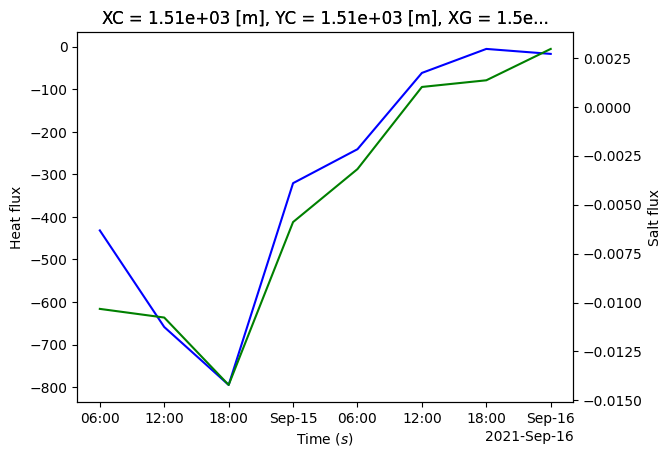

In [159]:
# Plotting
fig, ax = plt.subplots()
ax.set_title('Model contents')

ds['HF'].plot(ax=ax, label='Model heat flux', c='b')
ax.set_xlabel('Time ($s$)')
ax.set_ylabel('Heat flux')

ax2 = ax.twinx()
ds['SF'].plot(ax=ax2, label='Model salt flux', c='g')
ax2.set_ylabel('Salt flux')

## Conclusion

I believe salt content / brine rejection come into play by densifying the surface throughout the winter and eroding stratification. Then a pulse of heat loss causes rapid sinking. Immediately afterwards, there is a negative flux of salt associated with fresh and cold surface water moving down; we don't see warm/salty CDW coming up in this dataset due to the location and vertical/time fidelity, but we probably will see it in the vicinity of the plume in the model. Hence I will force the model with the surface heat flux (roughly based on the values from here) but NOT surface salt flux; the inner-plume salinity is dominated by sea water dynamics, not some kind of rapid ice pulse (again: ice processes come into play by affecting the pre-stratification so that a plume can be triggered by HF). Also note that the surface heat flux in the spring "storm" (or whatever caused it) is likely much stronger than shown here since this integrated calculation likely accounts for some warm water coming up over the course of the day. 

## Bonus: What is the stratification like immediately before the plume?

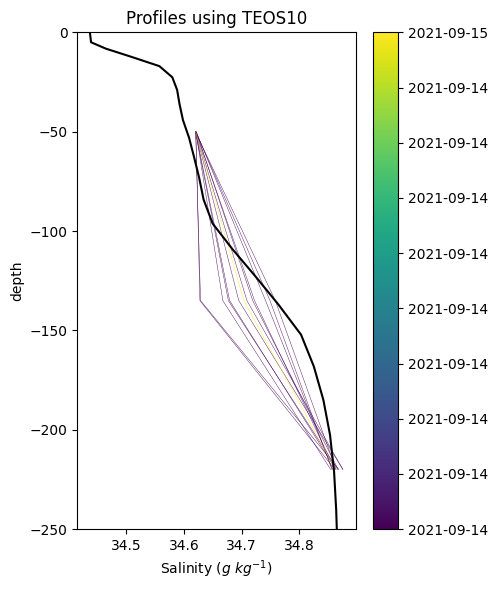

In [29]:
from datetime import datetime, timedelta # For handling dates and times

# Init the figure
fig, ax = plt.subplots(figsize=(5,6))
ax.set_ylabel('Depth ($m$)')

# Slice the mooring data that we want
ds = ds.sel(day=slice('2021-09-01T00:00:00.000000000','2021-09-15T00:00:00.000000000'))

# Get dates
dates = [pd.Timestamp(day) for day in ds['day'].values]

# Plot mooring data in a loop
norm = plt.Normalize(dates[0].toordinal(), dates[-1].toordinal()) # This is for hanlding the colouring of the lines 
cmap = plt.cm.viridis # "viridis" is a nice colourmap that isn't, usually, a problem for people with colourblindness
for n, date in enumerate(dates): # Looping through each date...
    c = cmap(norm(date.toordinal())) # Obtaining the colour 
    ds['SA'].isel(day=n).dropna('depth').plot(y='depth',ax=ax, color=c, lw=0.3)

# The following is almost directly from Copilot, and it handles the colourbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm) 
cbar = plt.colorbar(sm, ax=ax)
tick_locs = np.linspace(dates[0].toordinal(), dates[-1].toordinal(), len(dates[:10:]))
cbar.set_ticks(tick_locs)
cbar.set_ticklabels([pd.Timestamp.fromordinal(int(tick)).strftime('%Y-%m-%d') for tick in tick_locs])

# Comparing to the WOA-based binaries that I've been initialising with
open_bin = lambda f : xmitgcm.utils.read_raw_data('../MITgcm/so_plumes/binaries/'+f, shape=(50,100,100), dtype=np.dtype('>f4') )
depths = xmitgcm.open_mdsdataset('../MITgcm/so_plumes/mrb_028/',geometry='cartesian',prefix=['S','T'],iters=[0])['Z'].values
ax.plot(open_bin('SA.WOA2015.50x100x100.autumn.bin')[:,50,50],depths,c='k')

ax.set_ylim(-250,0)
ax.set_xlabel('Salinity ($g$ $kg^{-1}$)')
plt.title('Profiles using TEOS10')
plt.tight_layout()